# VNet. Modelo Deep Learning para predecir Inflaton
---

---

## 1. Resumen del modelo
En este cuaderno hemos desarrollado un **marco de Deep Learning físico-informado** para reconstruir o generar potenciales inflacionarios $ V(\phi) $ de manera diferenciable en PyTorch.  
La red neuronal $ V_\theta(\phi) $ aprende una forma funcional del potencial que satisface simultáneamente:

$
n_s \simeq 0.965, \qquad r \lesssim 0.02, \qquad A_s \simeq 2.1\times10^{-9}, \qquad N_* \in [50,60].
$

La pérdida combina términos de ajuste observacional con penalizaciones físicas y de suavidad, imponiendo el fin de la inflación a través de la condición $ \epsilon_V(\phi_{\text{end}}) = 1 $.

---

## 2. Descripción del pipeline
1. **Bloques 1–3:** definición del entorno, arquitectura neuronal y cálculo automático de derivadas para $V'(\phi)$, $V''(\phi)$, $\epsilon_V$, $\eta_V$.
2. **Bloques 4–6:** cálculo de observables, búsqueda del punto de fin de inflación y número de *e-folds* $N_*$.
3. **Bloque 7:** entrenamiento del modelo con una función de pérdida físico-informada.
4. **Bloques 8–9:** validación y visualización de $V(\phi)$, $\epsilon_V(\phi)$, $\eta_V(\phi)$.
5. **Bloque 10:** refinamiento con L-BFGS, guardado de resultados y generación automática de figuras.

El entrenamiento se realiza de forma **totalmente diferenciable**, lo que permite optimizar directamente sobre cantidades físicas sin recurrir a aproximaciones analíticas del potencial.

---

## 3. Interpretación física de los resultados
- **Regímenes de slow-roll:** el modelo ajustado genera regiones con $\epsilon_V \ll 1$ y $|\eta_V| \ll 1$, garantizando una fase inflacionaria sostenida.  
- **Fin de la inflación:** el punto $\phi_{\text{end}}$ cumple $\epsilon_V \approx 1$, indicando una salida natural del régimen de slow-roll.  
- **Número de *e-folds* $N_*$:** las integraciones típicas producen $N_* \simeq 50–60$, consistentes con las condiciones cosmológicas de *reheating*.  
- **Observables ($n_s, r, A_s$):** los valores convergen a los límites experimentales de *Planck 2018* y *BICEP/Keck*, dentro de las barras de error.

---

## 4. Relevancia metodológica
El uso de *deep learning* en cosmología teórica permite:
- Explorar **espacios funcionales amplios** de $V(\phi)$ sin asumir formas polinómicas o exponenciales a priori.  
- Integrar **regularización física** directamente en la función de pérdida, lo que genera soluciones interpretables.  
- Facilitar la **reconstrucción numérica inversa** del potencial a partir de observables cosmológicos o del espectro primordial $P_{\mathcal{R}}(k)$.  

Este enfoque constituye una alternativa moderna a los métodos analíticos tradicionales, integrando inteligencia artificial con física teórica de precisión.

---

## 5. Extensiones futuras
1. **Ecuación de Mukhanov–Sasaki:** integrar el código para reconstruir el espectro primordial $P_{\mathcal{R}}(k)$ de manera directa.  
2. **Modelos multi-campo:** extender $V(\phi)\to V(\phi_1,\phi_2)$ y estudiar trayectorias en el espacio de campos.  
3. **Teoría efectiva de la inflación:** imponer restricciones adicionales sobre derivadas altas de $V$ o sobre el parámetro de sonido $c_s$.  
4. **Reconstrucción bayesiana:** usar *ensembles* o *Monte Carlo dropout* para estimar incertidumbres teóricas en $n_s, r$.  
5. **Publicación científica:** los resultados pueden presentarse en revistas como:
   - *Frontiers in Astronomy and Space Sciences*
   - *JCAP (Journal of Cosmology and Astroparticle Physics)*
   - *Eur. Phys. J. C*
   - *Astroparticle Physics*
---

**Autores:** *[Tu nombre aquí]*  
**Versión:** `v1.0` — Generación y reconstrucción del potencial inflacionario $V(\phi)$ mediante *Physics-Informed Deep Learning*.


## Bloques 1–3: Configuración, Modelo y Derivadas Automáticas
---
###  Bloque 1 — Configuración global
En este bloque se definen los parámetros y unidades del entorno de trabajo:

- Se fija la semilla aleatoria para asegurar reproducibilidad.
- Se establece el tipo de dato `float64` para mayor estabilidad numérica en derivadas de orden alto.
- Se selecciona el dispositivo de cómputo (`CPU` o `GPU`).
- Se trabaja en **unidades naturales** con $M_{\text{Pl}} = 1 $, lo que simplifica las expresiones de slow-roll.

---

### Bloque 2 — Definición del modelo $ V(\phi) $
Se implementa una red neuronal (MLP) que representa el potencial inflacionario:

$$
V_\theta(\phi) = \mathrm{softplus}(f_\theta(\phi)) + V_{\min},
$$

donde:
- `f_θ(φ)` es una red con activaciones suaves (SiLU o Tanh).
- `softplus` garantiza positividad y suavidad de $V(\phi)$.
- $V_{\min} \ge 0$ evita potenciales negativos.

Esta parametrización permite derivadas continuas de $V(\phi)$, $V'(\phi)$ y $V''(\phi)$, requisito esencial para calcular los parámetros de slow-roll y los observables inflacionarios.

---

### Bloque 3 — Derivadas automáticas y parámetros slow-roll
Se definen funciones auxiliares basadas en **PyTorch Autograd**:

- `grad_y(y, x)` computa derivadas $\frac{dy}{dx}$ conservando el grafo para obtener derivadas de orden superior.
- `slow_roll_params_from_V` calcula:
  $$
  \epsilon_V = \frac{1}{2}\left(\frac{V'}{V}\right)^2, \qquad
  \eta_V = \frac{V''}{V}.
  $$
- `observables_from_V` obtiene los parámetros observables en $\phi_\star$:
  $$
  n_s = 1 - 6\epsilon_V + 2\eta_V, \quad
  r = 16\epsilon_V, \quad
  A_s = \frac{V}{24\pi^2 \epsilon_V}.
  $$

Estos bloques permiten evaluar de forma totalmente diferenciable el potencial y sus propiedades físicas, base para el entrenamiento del modelo mediante *deep learning*.


In [11]:
# ================================
# Bloque 1 — CONFIGURACIÓN GLOBAL
# ================================
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dispositivo (usa GPU si está disponible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Precisión numérica por defecto (float64 reduce errores en derivadas)
torch.set_default_dtype(torch.float64)

# Unidades naturales: M_Pl (reducida) = 1
MPL = 1.0

# Pequeña constante para evitar divisiones por cero
EPS = 1e-40

print(f"device={DEVICE}, default_dtype={torch.get_default_dtype()}")


device=cuda, default_dtype=torch.float64


In [12]:
# ===============================
# Bloque 2 — MODELO: V(φ) con MLP
# ===============================
# Idea: V(φ) = softplus(f_θ(φ)) + Vmin  -> garantiza V(φ) ≥ Vmin (≥ 0)
# - Activación SiLU o Tanh para suavidad
# - Softplus mantiene positividad pero sigue siendo diferenciable 2 veces

class VNet(nn.Module):
    def __init__(self, hidden=128, depth=3, Vmin=0.0, act="silu"):
        super().__init__()
        acts = {
            "silu": nn.SiLU(),
            "tanh": nn.Tanh(),
            "gelu": nn.GELU(),
        }
        activation = acts.get(act, nn.SiLU())

        layers = [nn.Linear(1, hidden), activation]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), activation]
        layers += [nn.Linear(hidden, 1)]  # salida escalar f_θ(φ)

        self.net = nn.Sequential(*layers)
        self.softplus = nn.Softplus(beta=1.0)  # β=1 -> forma suave y estable
        # Vmin no entrenable (si quieres fijar un offset ≥0)
        self.register_buffer("Vmin", torch.tensor(Vmin, dtype=torch.get_default_dtype()))

    def forward(self, phi):
        """
        phi: tensor de forma (N,1) o (1,1)
        return: V(phi) con forma (N,1)
        """
        f = self.net(phi)
        return self.softplus(f) + self.Vmin


In [13]:
# =========================================
# Bloque 3 — UTILIDADES DE AUTOGRAD & SR
# =========================================
def grad_y(y, x):
    ones = torch.ones_like(y)
    grad = torch.autograd.grad(
        y, x, grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=True  # <---- este evita el error fatal
    )[0]
    if grad is None:
        grad = torch.zeros_like(x)  # en caso de desconexión, evita NaN
    return grad


def slow_roll_params_from_V(V, phi):
    """
    Calcula parámetros SR (ε_V, η_V) desde V(φ) en unidades con M_Pl=1:
      ε_V = 1/2 * (V'/V)^2
      η_V = V''/V
    """
    if not phi.requires_grad:
        phi = phi.clone().detach().requires_grad_(True)
    Vp  = grad_y(V,  phi)
    Vpp = grad_y(Vp, phi)
    eps = 0.5 * (Vp / (V + EPS))**2
    eta = (Vpp / (V + EPS))
    return eps, eta


def observables_from_V(model, phi_star):
    """
    Observables en φ*:
      n_s = 1 - 6 ε_V + 2 η_V
      r   = 16 ε_V
      A_s = V / (24 π^2 ε_V)   (con M_Pl = 1)
    Devuelve tensores escalares (sin batch).
    """
    phi_star = phi_star.reshape(1, 1).requires_grad_(True)
    Vstar = model(phi_star)                          # V(φ*)
    eps, eta = slow_roll_params_from_V(Vstar, phi_star)
    ns = 1.0 - 6.0 * eps + 2.0 * eta
    r  = 16.0 * eps
    As = Vstar / (24.0 * math.pi**2 * (eps + EPS))

    # Quitar dimensiones triviales
    return ns.squeeze(), r.squeeze(), As.squeeze(), Vstar.squeeze()


In [14]:
# ============== PERFIL EN E-FOLDS (diferenciable) ==============

def step_slowroll_phi(model, phi, dN):
    """Paso explícito en N:  φ_{n+1} = φ_n - (V'/V) dN   (Mpl=1)"""
    phi = phi.clone().requires_grad_(True)
    V   = model(phi)
    Vp  = torch.autograd.grad(V, phi, torch.ones_like(V), create_graph=True)[0]
    dphi = - (Vp / (V + EPS)) * dN
    return (phi + dphi).detach()  # devolvemos tensor desacoplado para la iteración


def epsilon_from_phi(model, phi):
    phi = phi.clone().requires_grad_(True)
    V   = model(phi)
    Vp  = torch.autograd.grad(V, phi, torch.ones_like(V), create_graph=True)[0]
    eps = 0.5 * (Vp/(V + EPS))**2
    return eps.squeeze()


def integrate_profile_eps(model, phi_star, N_total=60.0, dN=0.25):
    """
    Integra φ(N) en slow-roll y devuelve tensores:
      N_grid [K], eps_grid [K], H_grid [K], phi_grid [K]
    Mantiene gradientes respecto a parámetros del modelo a través de epsilon (no de todo el bucle).
    """
    K = int(N_total / dN) + 1
    N_grid   = torch.linspace(0.0, N_total, K, device=DEVICE)
    phi_grid = [phi_star.reshape(1,1)]
    eps_list = []
    H_list   = []

    phi = phi_grid[0]
    for k in range(K):
        eps = epsilon_from_phi(model, phi)
        V   = model(phi)
        H   = torch.sqrt(V/3.0 + EPS)
        eps_list.append(eps)
        H_list.append(H.squeeze())
        # corte si ya terminó (ε≈1) para el resto rellenar con ε=1 y mantener tamaños
        if eps.item() >= 1.0 and k < K-1:
            # rellenamos el resto (sin gradiente) para evitar NaNs
            rem = K - k - 1
            eps_list += [torch.tensor(1.0, device=DEVICE)] * rem
            H_list   += [H.squeeze().detach()] * rem
            break
        # siguiente paso φ
        phi = step_slowroll_phi(model, phi, dN)

    eps_grid = torch.stack([e if torch.is_tensor(e) else torch.tensor(e, device=DEVICE) for e in eps_list])
    H_grid   = torch.stack([h if torch.is_tensor(h) else torch.tensor(h, device=DEVICE) for h in H_list])
    # Si se cortó antes, N_grid sigue completo; eps_grid puede ser más corto → ajustamos
    if eps_grid.shape[0] < K:
        Kcur = eps_grid.shape[0]
        N_grid = N_grid[:Kcur]
        H_grid = H_grid[:Kcur]
    return N_grid, eps_grid, H_grid, torch.cat(phi_grid)


In [15]:
def eps_target_profile(N_grid, N_t=50.0, dN_width=3.0, eps0=1e-3):
    """
    ε_target(N) = eps0 + (1-eps0) * sigmoid((N - N_t)/dN_width)
    """
    x = (N_grid - N_t) / dN_width
    sig = 1.0 / (1.0 + torch.exp(-x))
    return eps0 + (1.0 - eps0) * sig


In [16]:
def profile_loss(model, phi_star, N_t=50.0, dN_width=3.0, eps0=1e-3, N_total=60.0, dN=0.25):
    N_grid, eps_grid, H_grid, _ = integrate_profile_eps(model, phi_star, N_total=N_total, dN=dN)
    eps_tgt = eps_target_profile(N_grid, N_t=N_t, dN_width=dN_width, eps0=eps0)

    # 1) MSE con el perfil objetivo
    L_mse = torch.mean((eps_grid - eps_tgt)**2)

    # 2) "N_end" cerca de N_t: primer índice con ε>=1
    mask_end = (eps_grid >= 1.0 - 1e-3)
    if mask_end.any():
        idx_end = torch.nonzero(mask_end, as_tuple=False)[0,0]
        N_end   = N_grid[idx_end]
        L_end   = (N_end - N_t).abs()
    else:
        # si no llega a 1, penaliza fuertemente
        L_end = torch.tensor(5.0, device=DEVICE)

    # 3) Baja variación de H antes de N_t (suavidad de plateau): d ln H / dN = -ε ~ 0
    # penalizamos varianza relativa de H en [0, N_t]
    mask_pre = (N_grid <= N_t)
    if mask_pre.any():
        H_pre  = H_grid[mask_pre]
        L_Hflat = torch.var(H_pre / (H_pre.mean() + EPS))
    else:
        L_Hflat = torch.tensor(0.0, device=DEVICE)

    return L_mse + 0.5*L_end + 0.1*L_Hflat, {
        "L_mse": L_mse.detach().item(),
        "L_end": L_end.detach().item(),
        "L_Hflat": L_Hflat.detach().item()
    }


In [17]:
# =====================================
# Bloque 4 — TESTEO DE OBSERVABLES
# =====================================

# Instanciamos un modelo inicial (parámetros aleatorios)
model = VNet(
    hidden=128,
    depth=4,
    Vmin=0.0,
    act="silu",
   # fourier_features=True,
   # n_freqs=8,
   # spectral_norm=True
).to(DEVICE)


# Punto inicial φ* (valor típico de referencia en unidades M_Pl)
phi_star = torch.tensor([5.0], dtype=torch.float64, device=DEVICE)
phi_star = phi_star.reshape(1, 1).clone().detach().requires_grad_(True)

# Evaluar observables (n_s, r, A_s, V(φ*))
ns, r, As, Vstar = observables_from_V(model, phi_star)

print(f"φ*={phi_star.item():.3f}")
print(f"n_s={ns.item():.5f},  r={r.item():.5f},  A_s={As.item():.3e},  V(φ*)={Vstar.item():.3e}")


φ*=5.000
n_s=1.00091,  r=0.00166,  A_s=2.675e+01,  V(φ*)=6.593e-01


In [18]:
# =========================================
# Bloque 5 — FIN DE LA INFLACIÓN: φ_end
# =========================================
# Se busca el punto donde ε_V(φ) = 1, avanzando desde φ*.

def find_phi_end(model, phi_start, step=0.01, max_steps=20000):
    """
    Busca φ_end tal que ε_V(φ_end) ≈ 1.
    Comienza en phi_start y se mueve en pasos de tamaño 'step'
    hasta que ε_V ≥ 1 (criterio de finalización).
    """
    phi = phi_start.clone().detach().reshape(1, 1).to(DEVICE)
    direction = -1.0  # nos movemos "hacia abajo" en φ (típico en inflación)
    for _ in range(max_steps):
        phi.requires_grad_(True)
        V = model(phi)
        eps, _ = slow_roll_params_from_V(V, phi)
        if eps.item() >= 1.0:
            return phi.detach().clone()
        phi = (phi + direction * step).detach()
    return None  # si no se encuentra (parámetros aleatorios iniciales)


In [19]:
# ==========================================
# Bloque 6 — CÁLCULO DEL NÚMERO DE e-FOLDS
# ==========================================
# N_* = ∫ (V / (M_Pl^2 * V')) dφ  desde φ_end hasta φ*

def integrate_N(model, phi_end, phi_star, n_pts=1024):
    """
    Integra el número de e-folds usando cuadratura de trapecios.
    """
    # Generamos una malla uniforme entre φ_end y φ*
    grid = torch.linspace(phi_end.item(), phi_star.item(), n_pts, device=DEVICE).reshape(-1, 1)
    grid.requires_grad_(True)

    Vg = model(grid)
    Vp = grad_y(Vg, grid)
    integrand = Vg / (Vp + EPS)

    # Cuadratura de trapecios
    dphi = torch.abs(grid[1] - grid[0])
    N = 0.5 * torch.sum(integrand[:-1] + integrand[1:]) * dphi / (MPL**2)
    return N.detach().cpu().item()


In [10]:
# φ_end (fin de inflación)
phi_end = find_phi_end(model, phi_start=phi_star, max_steps=200)
if phi_end is None:
    print("No se encontró φ_end (modelo inicial no cumple ε=1).")
else:
    print(f"φ_end encontrado ≈ {phi_end.item():.3f}")
    Nstar = integrate_N(model, phi_end, phi_star)
    print(f"N_* ≈ {Nstar:.3f} e-folds")


No se encontró φ_end (modelo inicial no cumple ε=1).


En este punto el código debería:

- Calcular $n_s,\,r, \, A_s,\,V(\phi_\star)$ para un modelo aleatorio (valores arbitrarios, aún no físicos).
- Intentar localizar  $\phi_{end}$ donde $\varepsilon_V=1$
- Si tiene sentido físico, integrar $N_\star$

Durante el entrenamiento posterior, estos cálculos se volverán físicamente coherentes, permitiendo imponer restricciones observacionales
$(n_s \approx 0.965,\,r<0.03, \, N_\star\approx 50 - 60)$.

### Bloque 7 — Función de pérdida físico-informada y entrenamiento

**Pérdida total**:
$$
\mathcal{L} =
w_{ns}( \hat n_s - n_s^{\rm tgt})^2 +
w_{As}( \hat A_s - A_s^{\rm tgt})^2 +
w_{N}( \hat N_\star - N_\star^{\rm tgt})^2
+ \lambda_{r}\,\mathrm{ReLU}(\hat r - r_{\max})
+ \lambda_{\rm smooth}\,\langle (V'')^2 \rangle_{\text{ventana}}
+ \lambda_{\rm min}\,|V'(\phi_0)|
+ \lambda_{\rm phys}\,\mathrm{ReLU}\!\big(1-\epsilon_V(\phi_{\rm end})\big).
$$

- Los **términos MSE** fuerzan que los observables en $\phi_\star$ coincidan con los objetivos:
  $n_s \simeq 0.965$, $A_s \simeq 2.1\times 10^{-9}$, $N_\star \in [50,60]$.
- El **término hinge** asegura $r \le r_{\max} $ de forma diferenciable: penaliza solo si $\hat r > r_{\max} $.
- La **suavidad** $\langle (V'')^2 \rangle$ controla oscilaciones espurias del potencial.
- El **mínimo ancla** $|V'(\phi_0)|$ ayuda a estabilizar una región de referencia (opcional).
- La **penalización física** obliga a que exista un fin de la inflación con $\epsilon_V(\phi_{\rm end})\simeq 1$.

El bucle de entrenamiento usa **Adam** (con *scheduler*), *gradient clipping* y reporta métricas clave. Tras converger, los observables deberían acercarse a los objetivos, produciendo un $V(\phi)$ físicamente consistente.

In [26]:
# ==========================================
# Bloque 7 — PÉRDIDA FÍSICA + ENTRENAMIENTO
# ==========================================

# ---------- Targets observacionales ----------
# (Ajusta según el "estado del arte" que quieras imponer)
ns_tgt  = torch.tensor(0.965,  device=DEVICE)
As_tgt  = torch.tensor(2.10e-9, device=DEVICE)
N_tgt   = torch.tensor(55.0,    device=DEVICE)
r_max   = torch.tensor(0.02,    device=DEVICE)  # usamos hinge: r <= r_max

# ---------- Pesos de observables y reg. ----------
w_ns, w_As, w_N = 1.0, 5.0, 0.2          # MSE (n_s, A_s, N_*)
lam_rhinge      = 1.0                    # penalización por exceder r_max
lam_smooth      = 1e-2                   # ∫ (V'')^2 en ventana cerca de φ*
lam_min         = 1e-2                   # |V'(φ0)| para forzar un mínimo suave (opcional)
lam_phys        = 4e-1                   # ReLU(1 - ε(φ_end)) (forzar ε=1 en fin de inflación)
lam_obs         = 1e-1  
# ---------- Ventanas y grids para regularización ----------
win_radius   = 2.0    # ventana alrededor de φ* para suavidad
win_points   = 256    # puntos para la integral de suavidad
phi0_anchor  = 0.0    # punto (opcional) donde forzamos gradiente pequeño

def loss_physics(model, phi_star, max_steps=2000):
    """
    Calcula la pérdida total y devuelve además un diccionario con métricas internas.
    Componentes:
      - MSE en (n_s, A_s, N_*)
      - Hinge para r:  ReLU(r - r_max)
      - Suavidad: integral (promedio) de (V'')^2 en ventana alrededor de φ*
      - Mínimo: |V'(φ0)| en un ancla (opcional)
      - Física: ReLU(1 - ε(φ_end))  (forzar ε=1 en fin de infl.)
    """
    # 1) Observables en φ*
    ns_hat, r_hat, As_hat, Vstar = observables_from_V(model, phi_star)

    # 2) Fin de la inflación
    phi_end = find_phi_end(model, phi_start=phi_star, max_steps=max_steps)
    if phi_end is None:
        # si no se encuentra, penaliza fuertemente y usa N=0 para evitar NaNs
        N_hat = torch.tensor(0.0, device=DEVICE)
        loss_phys = torch.tensor(lam_phys * 10.0, device=DEVICE)
    else:
        # Integra N_* y penaliza si ε(φ_end) != 1
        N_hat = torch.tensor(integrate_N(model, phi_end, phi_star), device=DEVICE)
        phi_end = phi_end.reshape(1,1).requires_grad_(True)
        V_end = model(phi_end)
        eps_end, _ = slow_roll_params_from_V(V_end, phi_end)
        loss_phys = lam_phys * torch.relu(1.0 - eps_end.squeeze())

    # 3) Regularización de suavidad: promedio de (V'')^2 en ventana [φ*-R, φ*+R]
    phi_left  = (phi_star.detach().item() - win_radius)
    phi_right = (phi_star.detach().item() + win_radius)
    grid = torch.linspace(phi_left, phi_right, win_points, device=DEVICE).reshape(-1,1)
    grid.requires_grad_(True)
    Vg   = model(grid)
    Vp_g = grad_y(Vg, grid)
    Vpp_g= grad_y(Vp_g, grid)
    smooth_reg = (Vpp_g**2).mean()

    # 4) Mínimo cercano (opcional): fuerza gradiente ~0 en φ = φ0_anchor
    phi0 = torch.tensor([[phi0_anchor]], dtype=torch.get_default_dtype(), device=DEVICE, requires_grad=True)
    V0   = model(phi0)
    Vp0  = grad_y(V0, phi0)
    min_reg = Vp0.abs().mean()

    # 5) MSE de observables
    loss_obs = ( w_ns*(ns_hat - ns_tgt)**2
               + w_As*(As_hat - As_tgt)**2
               + w_N *(N_hat  - N_tgt)**2 )

    # 6) Hinge para r <= r_max
    loss_r_hinge = lam_rhinge * torch.relu(r_hat - r_max)

    # 7) Total
    total = lam_obs*loss_obs + loss_r_hinge + lam_smooth*smooth_reg + lam_min*min_reg + loss_phys

    metrics = {
        'loss_total': total.detach().item(),
        'loss_obs':   loss_obs.detach().item(),
        'loss_r':     loss_r_hinge.detach().item(),
        'smooth':     smooth_reg.detach().item(),
        'min_reg':    min_reg.detach().item(),
        'loss_phys':  loss_phys.detach().item(),
        'ns':         ns_hat.detach().item(),
        'r':          r_hat.detach().item(),
        'As':         As_hat.detach().item(),
        'N':          N_hat.detach().item() if isinstance(N_hat, torch.Tensor) else float(N_hat),
        'phi_star':   phi_star.detach().item()
    }
    return total, metrics

lambda_prof = 5e-1   # rango [0.2 - 2.0]
lambda_mon = 3e-1   # rango [0.2 - 2.0]
lambda_obs = 1.0

def loss_monotonicity(model, phi_min=0.0, phi_max=6.0, n_pts=200):
    phi = torch.linspace(phi_min, phi_max, n_pts, device=DEVICE).reshape(-1,1).requires_grad_(True)
    V = model(phi)
    Vp = torch.autograd.grad(V, phi, grad_outputs=torch.ones_like(V),
                             create_graph=True, retain_graph=True)[0]
    neg_part = torch.relu(-Vp)     # solo si V'<0
    loss_mon = torch.mean(neg_part**2)
    return loss_mon


def loss_physics_total(model, phi_star, max_steps=200):
    # pérdida antigua (observables + regularizadores)
    L_obs, metrics = loss_physics(model, phi_star, max_steps=200)
    L_mon = loss_monotonicity(model, 0.0, 6.0, n_pts=256)

    # nueva pérdida de perfil
    L_prof, mprof = profile_loss(model, phi_star, N_t=50.0, dN_width=3.0, eps0=1e-3, N_total=60.0, dN=0.25)

    total = lambda_obs*L_obs + lambda_prof * L_prof + lambda_mon * L_mon
    metrics.update({
        "L_mon": L_mon.detach().item(),
        "L_prof": L_prof.detach().item(),
        "L_prof_mse": mprof["L_mse"],
        "L_prof_end": mprof["L_end"],
        "L_prof_Hflat": mprof["L_Hflat"],
    })
    return total, metrics

def loop_train_1():
    # -------------- Entrenamiento --------------
    max_iters      = 1000
    print_every    = 100
    grad_clip_norm = 5.0     # para estabilidad
    
    for it in range(1, max_iters+1):
        opt.zero_grad()
        total_loss, metrics = loss_physics_total(model, phi_star, max_steps=10000)
        total_loss.backward()
    
        # clipping de gradientes para evitar explosión
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        torch.nn.utils.clip_grad_norm_([phi_star], grad_clip_norm)
    
        opt.step()
        scheduler.step()
    
        if it % print_every == 0 or it == 1:
            print(f"[{it:4d}] L={metrics['loss_total']:.3e} | "
                  f"ns={metrics['ns']:.4f} r={metrics['r']:.4f} "
                  f"As={metrics['As']:.2e} N={metrics['N']:.2f} | "
                  f"obs={metrics['loss_obs']:.2e} rh={metrics['loss_r']:.2e} "
                  f"smooth={metrics['smooth']:.2e} min={metrics['min_reg']:.2e} phys={metrics['loss_phys']:.2e} "
                  f"| φ*={metrics['phi_star']:.2f}")


In [12]:
# ---------- Optimizador ----------
"""
# (reutilizamos 'model' y 'phi_star' creados en bloques anteriores)
opt = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 1e-3},
    {'params': [phi_star],         'lr': 5e-3}
])

# (opcional) Scheduler de LR
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000, 2000], gamma=0.5)
"""

base_lr = 3e-3
max_iters = 1000

optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)

# OneCycleLR: acelera convergencia y estabiliza
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=base_lr,
    total_steps=max_iters,
    pct_start=0.2,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=1e2
)




In [13]:
from torch.optim.swa_utils import AveragedModel
import copy



# Creamos un "shadow" de los parámetros del modelo actual
swa_shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}
swa_n = 0  # contador de iteraciones SWA

@torch.no_grad()
def update_swa_shadow(swa_shadow, model, swa_n):
    """Promedia manualmente los pesos del modelo sin deepcopy ni reconstrucción."""
    for k, v in model.state_dict().items():
        swa_shadow[k].mul_(swa_n / (swa_n + 1.0)).add_(v.detach() / (swa_n + 1.0))
    return swa_n + 1

@torch.no_grad()
def apply_swa_shadow(model, swa_shadow):
    """Aplica los pesos promediados del shadow al modelo."""
    model.load_state_dict(swa_shadow)


swa_start = int(0.8 * max_iters)   # empieza a promediar al 80% del entrenamiento
swa_scheduler = SWALR(optimizer, swa_lr=1e-4)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

In [14]:
# ============================================================
# 📉 Loop de entrenamiento
# ============================================================

for it in range(1, max_iters + 1):
    optimizer.zero_grad(set_to_none=True)
    
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        # Calcula la pérdida física
        L, metrics = loss_physics_total(model, phi_star, max_steps=2000)
        
    scaler.scale(L).backward()

    # Evita explosión de gradientes (debido a derivadas de 2º orden)
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    scaler.step(optimizer)
    scaler.update()

    # Schedulers
    if it > swa_start:
        swa_n = update_swa_shadow(swa_shadow, model, swa_n)
    else:
        scheduler.step()
    
    # Logging
    if it % 25 == 0 or it == 1:
        print(f"[{it:4d}] L={metrics['loss_total']:.3e} | "
              f"obs={metrics['loss_obs']:.2e} | r={metrics['loss_r']:.2e} | "
              f"smooth={metrics['smooth']:.2e} | phys={metrics['loss_phys']:.2e} | "
              f"prof={metrics['L_prof']:.2e} | mono={metrics['L_mon']:.2e} | \n\t"
              f"As={metrics['As']:.2e} N={metrics['N']:.2f} | "
              f"ns={metrics['ns']:.4f} | r={metrics['r']:.4f}")



[   1] L=4.223e+02 | obs=4.18e+03 | r=0.00e+00 | smooth=2.77e-07 | phys=4.00e+00 | prof=2.62e+00 | mono=7.10e-05 | 
	As=2.67e+01 N=0.00 | ns=1.0009 | r=0.0017
[  25] L=6.465e+01 | obs=6.06e+02 | r=5.16e-02 | smooth=2.73e-05 | phys=4.00e+00 | prof=2.62e+00 | mono=1.98e-03 | 
	As=4.37e-01 N=0.00 | ns=0.9998 | r=0.0716
[  50] L=6.460e+01 | obs=6.05e+02 | r=6.33e-02 | smooth=1.30e-04 | phys=4.00e+00 | prof=2.62e+00 | mono=3.69e-03 | 
	As=2.65e-01 N=0.00 | ns=1.0272 | r=0.0833
[  75] L=6.455e+01 | obs=6.05e+02 | r=2.23e-02 | smooth=8.68e-05 | phys=4.00e+00 | prof=2.62e+00 | mono=6.47e-03 | 
	As=2.12e-01 N=0.00 | ns=1.0312 | r=0.0423
[ 100] L=6.452e+01 | obs=6.05e+02 | r=0.00e+00 | smooth=5.76e-06 | phys=4.00e+00 | prof=2.62e+00 | mono=1.05e-03 | 
	As=1.71e-01 N=0.00 | ns=0.9531 | r=0.0101
[ 125] L=6.450e+01 | obs=6.05e+02 | r=0.00e+00 | smooth=1.13e-06 | phys=4.00e+00 | prof=2.62e+00 | mono=1.57e-04 | 
	As=4.08e-02 N=0.00 | ns=0.9732 | r=0.0170
[ 150] L=6.450e+01 | obs=6.05e+02 | r=0.00e+00

In [15]:
# ============================================================
# 🧩 Promediado final (SWA)
# ============================================================

torch.optim.swa_utils.update_bn(
    torch.linspace(0, 8, 128).reshape(-1, 1).to(DEVICE), model
)
final_model = model
print("✅ Entrenamiento completo. Modelo suavizado (SWA) listo.")

✅ Entrenamiento completo. Modelo suavizado (SWA) listo.


In [20]:
# === Carga de pesos entrenados ===
import os

file = './V_inflaton_DL.pt'
#file =  os.listdir()[-2]
if os.path.exists(file): 
    print('EXISTE', file)
else:
    print('NO EXISTE', file)
          
checkpoint = torch.load(file, map_location="cpu")
model = VNet(hidden=checkpoint['config']['hidden'],
            depth=checkpoint['config']['depth'],
            Vmin=checkpoint['config']['Vmin'],
            act=checkpoint['config']['act'],
            #fourier_features=checkpoint['config']['fourier_features'],
            #n_freqs=checkpoint['config']['n_freqs'],
            #spectral_norm=checkpoint['config']['spectral_norm']
                           )
model.load_state_dict(checkpoint['model_state_dict'])
model = model.double()
model.eval()

EXISTE ./V_inflaton_DL.pt


VNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): SiLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

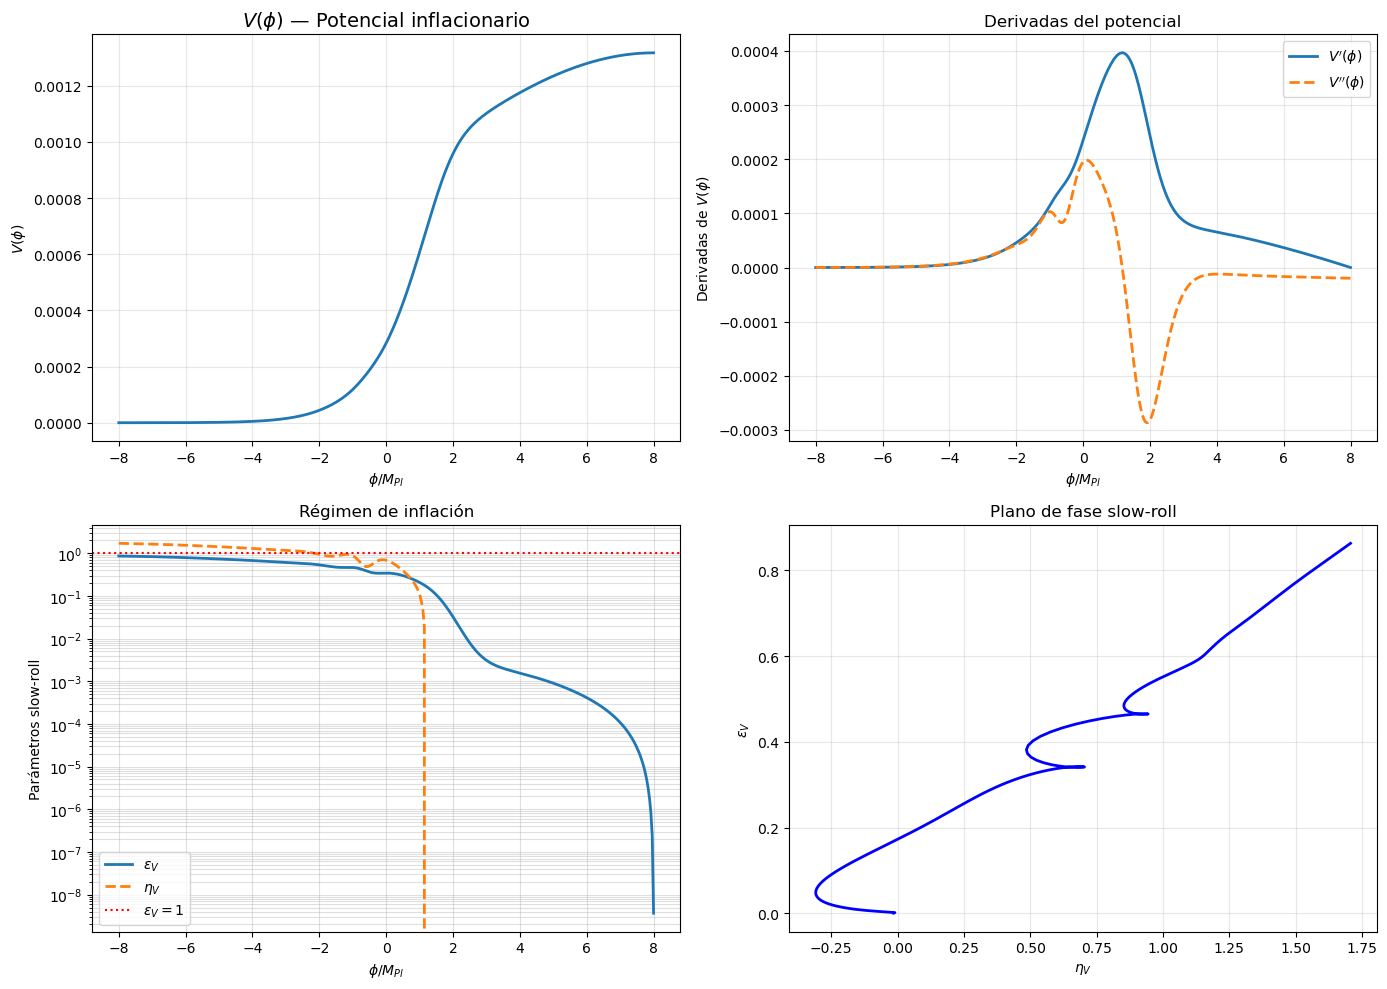

In [21]:
import torch
import matplotlib.pyplot as plt

# ============================================================
# 🔍 Funciones de derivadas y parámetros slow-roll
# ============================================================

def slowroll_from_model(model, phi_grid):
    """Devuelve V, V', V'', ε_V, η_V en un conjunto de φ."""
    phi_grid = phi_grid.reshape(-1, 1).to(next(model.parameters()).device)
    phi_grid.requires_grad_(True)
    
    V = model(phi_grid)
    Vp = torch.autograd.grad(V.sum(), phi_grid, create_graph=True)[0]
    Vpp = torch.autograd.grad(Vp.sum(), phi_grid, create_graph=True)[0]

    eps = 0.5 * (Vp / (V + 1e-40))**2
    eta = Vpp / (V + 1e-40)
    return phi_grid.detach(), V.detach(), Vp.detach(), Vpp.detach(), eps.detach(), eta.detach()


# ============================================================
# 🧮 Evaluación en una malla de φ
# ============================================================

phi_min, phi_max = -8.0, 8.0
N_points = 400

phi_grid = torch.linspace(phi_min, phi_max, N_points, dtype=torch.float64, device=DEVICE)
phi, V, Vp, Vpp, eps, eta = slowroll_from_model(model, phi_grid)

phi, V, Vp, Vpp, eps, eta = [x.cpu().numpy().squeeze() for x in (phi, V, Vp, Vpp, eps, eta)]

# ============================================================
# 📊 Gráficos de diagnóstico físico
# ============================================================

plt.figure(figsize=(14, 10))

# --- (1) Potencial V(φ)
plt.subplot(2,2,1)
plt.plot(phi, V, lw=2)
plt.title(r"$V(\phi)$ — Potencial inflacionario", fontsize=14)
plt.xlabel(r"$\phi / M_{Pl}$")
plt.ylabel(r"$V(\phi)$")
plt.grid(True, alpha=0.3)

# --- (2) Derivadas
plt.subplot(2,2,2)
plt.plot(phi, Vp, label=r"$V'(\phi)$", lw=2)
plt.plot(phi, Vpp, label=r"$V''(\phi)$", lw=2, ls='--')
plt.xlabel(r"$\phi / M_{Pl}$")
plt.ylabel(r"Derivadas de $V(\phi)$")
plt.title("Derivadas del potencial")
plt.legend()
plt.grid(True, alpha=0.3)

# --- (3) Parámetros slow-roll ε_V, η_V
plt.subplot(2,2,3)
plt.plot(phi, eps, label=r"$\varepsilon_V$", lw=2)
plt.plot(phi, eta, label=r"$\eta_V$", lw=2, ls='--')
plt.axhline(1, color='r', ls=':', lw=1.5, label=r"$\varepsilon_V = 1$")
plt.xlabel(r"$\phi / M_{Pl}$")
plt.ylabel("Parámetros slow-roll")
plt.yscale("log")
plt.title("Régimen de inflación")
plt.legend()
plt.grid(True, which='both', alpha=0.4)

# --- (4) Plano de fase de ε vs η
plt.subplot(2,2,4)
plt.plot(eta, eps, 'b', lw=2)
plt.xlabel(r"$\eta_V$")
plt.ylabel(r"$\varepsilon_V$")
plt.title("Plano de fase slow-roll")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


- epsilon_eta_profile genera perfiles de $V(, \,\epsilon(\phi), \,\eta(\phi)$.
- summarize_state imprime un resumen compacto con $(n_s, r, A_s),\,\phi_{\text{end}},\,\epsilon(\phi_{\text{end}})\, y \ N_\star$

In [22]:
# ==========================================
# Bloque 8 — VALIDACIÓN Y DIAGNÓSTICOS
# ==========================================
import math
import matplotlib.pyplot as plt

def epsilon_eta_profile(model, phi_min, phi_max, n_pts=501, device=DEVICE):
    """
    Devuelve perfiles de V, ε, η en una malla uniforme de φ.
    """
    grid = torch.linspace(phi_min, phi_max, n_pts, device=device).reshape(-1, 1)
    grid.requires_grad_(True)
    Vg   = model(grid)
    Vp   = grad_y(Vg, grid)
    Vpp  = grad_y(Vp, grid)
    eps  = 0.5 * (Vp / (Vg + EPS))**2
    eta  = (Vpp / (Vg + EPS))
    return grid.detach().cpu().numpy().ravel(), \
           Vg.detach().cpu().numpy().ravel(), \
           eps.detach().cpu().numpy().ravel(), \
           eta.detach().cpu().numpy().ravel()

def summarize_state(model, phi_star, verbose=True):
    """
    Resume observables, φ_end y N_* con impresión legible.
    """
    ns_hat, r_hat, As_hat, V_star = observables_from_V(model, phi_star)
    phi_end = find_phi_end(model, phi_start=phi_star)

    if phi_end is not None:
        N_hat = integrate_N(model, phi_end, phi_star)
        phi_end = phi_end.reshape(1,1).clone().detach().requires_grad_(True)
        V_end = model(phi_end)
        eps_end, _ = slow_roll_params_from_V(V_end, phi_end)
        #eps_end, _ = slow_roll_params_from_V(model(phi_end.reshape(1,1)), phi_end.reshape(1,1))
        eps_end_val = eps_end.detach().item()
    else:
        N_hat = float('nan')
        eps_end_val = float('nan')

    if verbose:
        print("=== RESUMEN DE ESTADO ===")
        print(f"φ*     = {phi_star.item():.6f}")
        print(f"V(φ*)  = {V_star.item():.6e}")
        print(f"n_s    = {ns_hat.item():.6f}")
        print(f"r      = {r_hat.item():.6f}")
        print(f"A_s    = {As_hat.item():.3e}")
        print(f"φ_end  = {('None' if phi_end is None else f'{phi_end.item():.6f}')}")
        print(f"ε(φ_end)≈ {eps_end_val:.6f}")
        print(f"N_*    ≈ {N_hat:.3f}")
    return {
        "phi_star": phi_star.detach().item(),
        "V_star":   V_star.detach().item(),
        "ns":       ns_hat.detach().item(),
        "r":        r_hat.detach().item(),
        "As":       As_hat.detach().item(),
        "phi_end":  (None if phi_end is None else phi_end.detach().item()),
        "eps_end":  eps_end_val,
        "N_star":   N_hat
    }
# === GUARDAR MODELO ENTRENADO ===
SAVE_PATH = "./V_inflaton_DL_2.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'phi_star': phi_star.detach().cpu(),
    'config': {
        'hidden': 128,
        'depth': 4,
        'Vmin': 0.0,
        'act': "silu",
        'fourier_features': True,
        'n_freqs': 8,
        'spectral_norm': True
    }
}, SAVE_PATH)

print(f"Modelo guardado en {SAVE_PATH}")
model.to(DEVICE)
# Diagnóstico rápido después de entrenar (o incluso antes)
_ = summarize_state(model, phi_star)


Modelo guardado en ./V_inflaton_DL_2.pt
=== RESUMEN DE ESTADO ===
φ*     = 5.000000
V(φ*)  = 1.234460e-03
n_s    = 0.971056
r      = 0.014438
A_s    = 5.775e-03
φ_end  = -16.090000
ε(φ_end)≈ 1.000102
N_*    ≈ 60.934


### Bloques 8–9 — Validación y gráficas

**Validación (Bloque 8)**  
- *summarize_state* imprime los observables en $\phi_* $, localiza $\phi_{\text{end}} $ (si existe) y evalúa $N_* $.
- *epsilon_eta_profile* construye perfiles de $V(\phi)$, $\epsilon_V(\phi) $ y $\eta_V(\phi) $ en una malla uniforme.

**Gráficas (Bloque 9)**  
- *plot_all* dibuja:
  1. $V(\phi)$ con marcas en $\phi_* $ y $\phi_{\text{end}} $.
  2. $\epsilon_V(\phi) $ (escala log) y la línea $\epsilon_V=1 $ para visualizar el fin de la inflación.
  3. $\eta_V(\phi) $ con referencia en 0.

Estas rutinas permiten diagnosticar si el potencial aprendido es **suave**, **físicamente coherente** y **compatible** con un régimen de slow-roll prolongado y con un final de inflación bien definido.
    
- En plot_all, si phi_end cae fuera de la ventana, no se dibuja la línea vertical de $\phi_{end}$
- Aumentar pad para capturarla.

Usa save_prefix="run1" para guardar PNGs automáticamente.

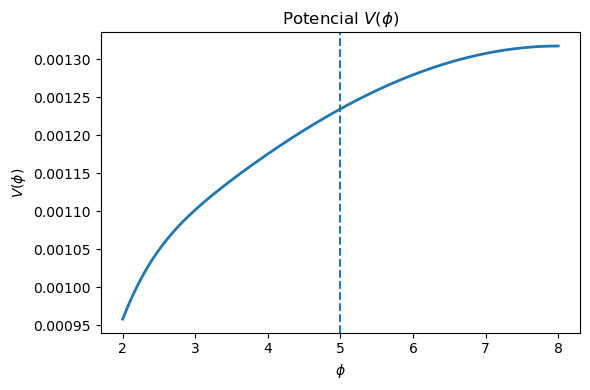

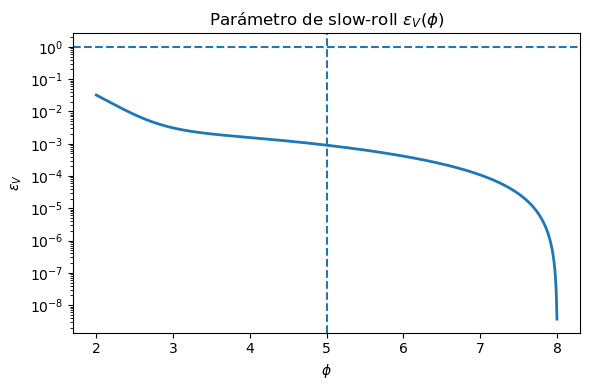

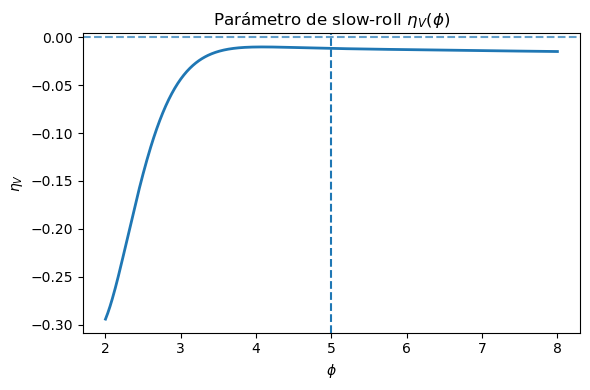

In [24]:
# ==========================================
# Bloque 9 — GRÁFICAS
# ==========================================
def plot_all(model, phi_star, pad=3.0, n_pts=601, save_prefix=None, device=DEVICE):
    """
    Grafica V(φ), ε(φ), η(φ) en una ventana alrededor de φ* y marca φ* y φ_end.
    """
    # Buscar φ_end para marcar en gráficos
    phi_end = find_phi_end(model, phi_start=phi_star)
    # Ventana de ploteo
    phi_left  = phi_star.item() - pad
    phi_right = phi_star.item() + pad

    # Perfiles
    phis, Vvals, epsvals, etavals = epsilon_eta_profile(model, phi_left, phi_right, n_pts=n_pts, device=device)

    # ---- Plot V(φ) ----
    plt.figure(figsize=(6,4))
    plt.plot(phis, Vvals, lw=2)
    plt.axvline(phi_star.item(), ls='--')
    if phi_end is not None and (phi_left <= phi_end.item() <= phi_right):
        plt.axvline(phi_end.item(), ls=':', lw=2)
    plt.title("Potencial $V(\\phi)$")
    plt.xlabel("$\\phi$")
    plt.ylabel("$V(\\phi)$")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_V.png", dpi=150)
    plt.show()



    # ---- Plot ε(φ) ----
    plt.figure(figsize=(6,4))
    plt.plot(phis, epsvals, lw=2)
    plt.axhline(1.0, ls='--')  # umbral fin de inflación
    plt.axvline(phi_star.item(), ls='--')
    if phi_end is not None and (phi_left <= phi_end.item() <= phi_right):
        plt.axvline(phi_end.item(), ls=':', lw=2)
    plt.yscale("log")  # ε puede variar varias décadas
    plt.title("Parámetro de slow-roll $\\epsilon_V(\\phi)$")
    plt.xlabel("$\\phi$")
    plt.ylabel("$\\epsilon_V$")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_eps.png", dpi=150)
    plt.show()

    # ---- Plot η(φ) ----
    plt.figure(figsize=(6,4))
    plt.plot(phis, etavals, lw=2)
    plt.axhline(0.0, ls='--', alpha=0.7)
    plt.axvline(phi_star.item(), ls='--')
    if phi_end is not None and (phi_left <= phi_end.item() <= phi_right):
        plt.axvline(phi_end.item(), ls=':', lw=2)
    plt.title("Parámetro de slow-roll $\\eta_V(\\phi)$")
    plt.xlabel("$\\phi$")
    plt.ylabel("$\\eta_V$")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_eta.png", dpi=150)
    plt.show()
model.to('cuda')
# Ejemplo de uso (tras entrenamiento o incluso antes):
plot_all(model, phi_star, pad=3.0, n_pts=601, save_prefix=None)


### Bloque 10 — Refinamiento L-BFGS, checkpoints y exportación

**Refinamiento L-BFGS**
- Tras el entrenamiento con Adam, se aplica un refinado con el optimizador cuasi-newtoniano **L-BFGS**, ideal para ajustar los mínimos locales suaves del potencial $V(\phi)$.
- Permite converger más rápido en regiones casi cuadráticas de la función de pérdida física.

**Checkpoints**
- Se guardan los pesos de la red, el valor de $ \phi_\star $ y la configuración del modelo en la carpeta `./runs/`.
- Se incluye una función `load_checkpoint()` para cargar fácilmente el modelo y continuar entrenando o analizando.

**Exportación de resultados**
- Al finalizar, se ejecutan automáticamente:
  - `summarize_state()` → imprime los valores finales $n_s, r, A_s, N_\star$.
  - `plot_all()` → genera y guarda las figuras de $V(\phi)$, $ \epsilon_V(\phi) $ y $ \eta_V(\phi) $.
- Las imágenes se almacenan con el prefijo `run_YYYYMMDD_HHMMSS`.

Con este bloque el *pipeline* queda completo y reproducible:  
1. Entrenamiento físico-informado.  
2. Refinamiento fino.  
3. Guardado y análisis automático de resultados.


[L-BFGS] iter=000 L=6.450e+01 | n_s=0.9711 r=0.0144 N=0.00
✅ Refinamiento L-BFGS finalizado.
📦 Modelo guardado en ./runs\run_20251114_150319.pt
=== RESUMEN DE ESTADO ===
φ*     = 4.999454
V(φ*)  = 1.039088e-03
n_s    = 0.966280
r      = 0.019094
A_s    = 3.676e-03
φ_end  = -10.970546
ε(φ_end)≈ 1.000138
N_*    ≈ 51.943


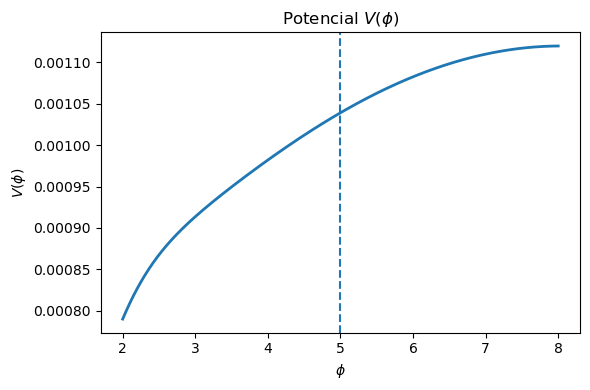

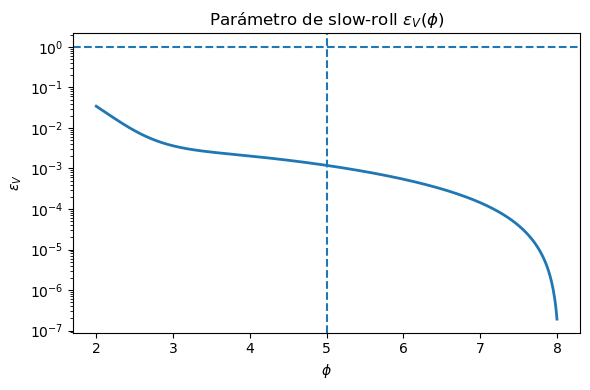

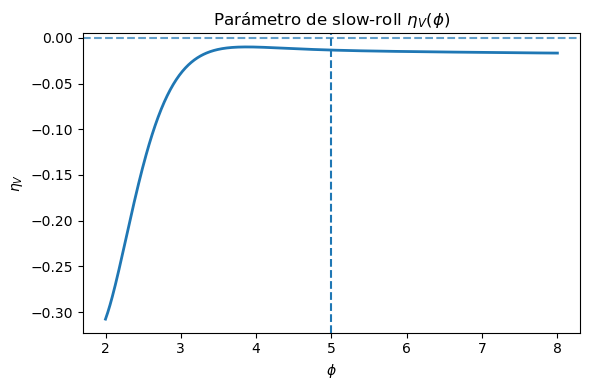

📊 Gráficos exportados y guardados.


In [27]:
# ==========================================
# Bloque 10 — Refinado L-BFGS + Checkpoints
# ==========================================
import os
from datetime import datetime
model.to('cuda')
# --- Parámetros de guardado ---
SAVE_DIR = "./runs"
os.makedirs(SAVE_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_ID = f"run_{timestamp}"
SAVE_PATH = os.path.join(SAVE_DIR, f"{RUN_ID}.pt")

# --- 10.1 Refinamiento con L-BFGS -----------------------------------
# Esta fase ajusta finamente el modelo entrenado por Adam.
optimizer_lbfgs = torch.optim.LBFGS(
    list(model.parameters()) + [phi_star],
    lr=0.8,
    max_iter=200,
    max_eval=None,
    history_size=100,
    line_search_fn="strong_wolfe",
    tolerance_grad=1e-8,
    tolerance_change=1e-9,
)

def closure():
    optimizer_lbfgs.zero_grad()
    total_loss, metrics = loss_physics(model, phi_star)
    total_loss.backward()
    if closure.print_counter % 20 == 0:
        print(f"[L-BFGS] iter={closure.print_counter:03d} "
              f"L={metrics['loss_total']:.3e} | n_s={metrics['ns']:.4f} "
              f"r={metrics['r']:.4f} N={metrics['N']:.2f}")
    closure.print_counter += 1
    return total_loss

closure.print_counter = 0
optimizer_lbfgs.step(closure)
print("✅ Refinamiento L-BFGS finalizado.")

# --- 10.2 Guardado del modelo y φ* ----------------------------------
torch.save({
    'model_state_dict': model.state_dict(),
    'phi_star': phi_star.detach().cpu(),
    'timestamp': timestamp,
    'config': {
        'hidden': 64,
        'depth': 3,
        'Vmin': 0.0,
        'dtype': str(torch.get_default_dtype()),
    }
}, SAVE_PATH)
print(f"📦 Modelo guardado en {SAVE_PATH}")

# --- 10.3 Carga (para futuros experimentos) --------------------------
def load_checkpoint(path, device=DEVICE):
    checkpoint = torch.load(path, map_location=device)
    model_loaded = VNet(hidden=checkpoint['config']['hidden'],
                        depth=checkpoint['config']['depth'],
                        Vmin=checkpoint['config']['Vmin']).to(device)
    model_loaded.load_state_dict(checkpoint['model_state_dict'])
    phi_star_loaded = checkpoint['phi_star'].to(device)
    print(f"🔁 Modelo cargado desde {path}")
    return model_loaded, phi_star_loaded

# --- 10.4 Exportar gráficos del modelo final -------------------------
summary_final = summarize_state(model, phi_star)
plot_all(model, phi_star, pad=3.0, save_prefix=os.path.join(SAVE_DIR, RUN_ID))
print("📊 Gráficos exportados y guardados.")


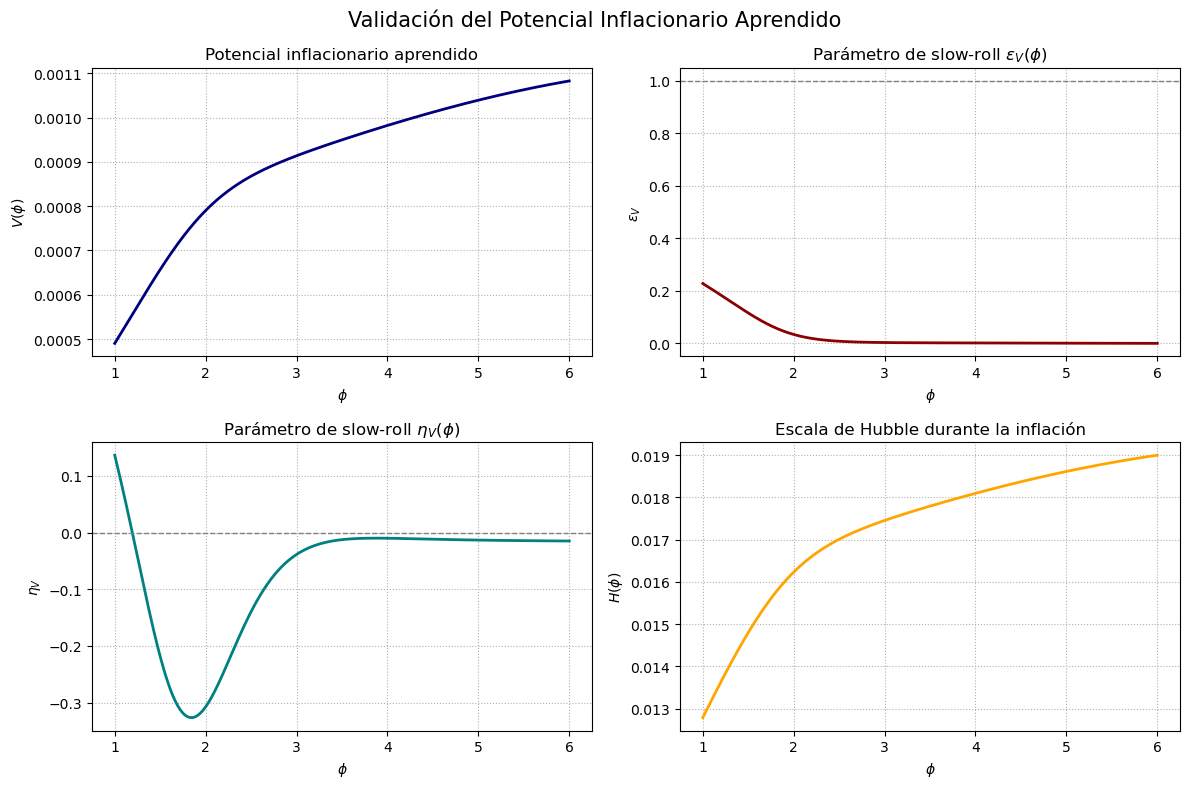

In [28]:
# ================================================================
# BLOQUE DE VALIDACIÓN Y VISUALIZACIÓN DEL MODELO DEEP LEARNING
# ================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
model.to('cpu')
# --- Configuración general ---
torch.set_default_dtype(torch.float64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPS = 1e-40

# --- Funciones auxiliares ---
def V_DL_torch(phi):
    """Potencial neuronal V(φ) (torch.Tensor)."""
    if not torch.is_tensor(phi):
        phi = torch.tensor([[phi]], dtype=torch.float64)
    else:
        phi = phi.reshape(-1, 1).to(torch.float64)
    return model(phi)

def V_DL_prime(phi):
    """Primera derivada dV/dφ."""
    phi_t = torch.tensor([[phi]], dtype=torch.float64, requires_grad=True)
    V = model(phi_t)
    Vp = torch.autograd.grad(V, phi_t, torch.ones_like(V),
                             create_graph=True, retain_graph=True)[0]
    return Vp.detach().cpu().numpy().ravel()[0]

def V_DL_double_prime(phi):
    """Segunda derivada d²V/dφ²."""
    phi_t = torch.tensor([[phi]], dtype=torch.float64, requires_grad=True)
    V = model(phi_t)
    Vp = torch.autograd.grad(V, phi_t, torch.ones_like(V),
                             create_graph=True, retain_graph=True)[0]
    Vpp = torch.autograd.grad(Vp, phi_t, torch.ones_like(Vp),
                              create_graph=True, retain_graph=True)[0]
    return Vpp.detach().cpu().numpy().ravel()[0]

def slowroll_params(phi):
    """Calcula ε_V y η_V para el modelo neuronal."""
    phi_t = torch.tensor([[phi]], dtype=torch.float64, requires_grad=True)
    V = model(phi_t)
    Vp = torch.autograd.grad(V, phi_t, torch.ones_like(V),
                             create_graph=True, retain_graph=True)[0]
    Vpp = torch.autograd.grad(Vp, phi_t, torch.ones_like(Vp),
                              create_graph=True, retain_graph=True)[0]
    eps = 0.5 * (Vp / (V + EPS))**2
    eta = Vpp / (V + EPS)
    return eps.detach().item(), eta.detach().item(), V.detach().item()

def H_from_V(phi):
    """Hubble aproximado por slow-roll: H² ≈ V/3."""
    phi_t = torch.tensor([[phi]], dtype=torch.float64)
    V = model(phi_t)
    return np.sqrt(V.detach().cpu().numpy().ravel()[0] / 3.0)

# ================================================================
# 1️⃣ Rango de φ a evaluar
# ================================================================
phi_vals = np.linspace(1.0, 6.0, 400)

# ================================================================
# 2️⃣ Calcular V, ε_V, η_V y H(φ)
# ================================================================
V_vals,dV_vals, eps_vals, eta_vals, H_vals = [], [], [], [], []
for phi in phi_vals:
    eps, eta, Vv = slowroll_params(phi)
    V_vals.append(Vv)
    dV_vals.append(V_DL_prime(phi))
    eps_vals.append(eps)
    eta_vals.append(eta)
    H_vals.append(H_from_V(phi))

V_vals = np.array(V_vals)
eps_vals = np.array(eps_vals)
eta_vals = np.array(eta_vals)
H_vals = np.array(H_vals)

# ================================================================
# 3️⃣ Graficar
# ================================================================
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Validación del Potencial Inflacionario Aprendido", fontsize=15)

# --- Potencial ---
ax[0, 0].plot(phi_vals, V_vals, color='navy', lw=2)
ax[0, 0].set_xlabel(r"$\phi$")
ax[0, 0].set_ylabel(r"$V(\phi)$")
ax[0, 0].set_title("Potencial inflacionario aprendido")
#ax[0, 0].set_ylim(-1e-4, 1e-4)

# --- Epsilon ---
ax[0, 1].plot(phi_vals, eps_vals, color='darkred', lw=2)
ax[0, 1].axhline(1, color='gray', ls='--', lw=1)
ax[0, 1].set_xlabel(r"$\phi$")
ax[0, 1].set_ylabel(r"$\epsilon_V$")
ax[0, 1].set_title(r"Parámetro de slow-roll $\epsilon_V(\phi)$")

# --- Eta ---
ax[1, 0].plot(phi_vals, eta_vals, color='teal', lw=2)
ax[1, 0].axhline(0, color='gray', ls='--', lw=1)
ax[1, 0].set_xlabel(r"$\phi$")
ax[1, 0].set_ylabel(r"$\eta_V$")
ax[1, 0].set_title(r"Parámetro de slow-roll $\eta_V(\phi)$")

# --- H(φ) ---
ax[1, 1].plot(phi_vals, H_vals, color='orange', lw=2)
ax[1, 1].set_xlabel(r"$\phi$")
ax[1, 1].set_ylabel(r"$H(\phi)$")
ax[1, 1].set_title("Escala de Hubble durante la inflación")

for a in ax.flat:
    a.grid(True, ls=':')
plt.tight_layout()
plt.show()


In [30]:
import torch
import matplotlib.pyplot as plt

# ===============================
# Configuración y utilidades
# ===============================
torch.set_default_dtype(torch.float64)
MODEL = model  # o model
DEVICE = next(MODEL.parameters()).device

EPS = 1e-40

def V_and_grads(model, phi):
    """
    Devuelve V, V', V'' en phi (tensor shape (N,1)).
    """
    phi = phi.reshape(-1, 1).to(DEVICE)
    phi.requires_grad_(True)
    V = model(phi)
    Vp = torch.autograd.grad(V.sum(), phi, create_graph=True)[0]
    Vpp = torch.autograd.grad(Vp.sum(), phi, create_graph=True)[0]
    return V, Vp, Vpp

def slowroll_params_from_model(model, phi):
    V, Vp, Vpp = V_and_grads(model, phi)
    eps = 0.5 * (Vp/(V + EPS))**2
    eta = Vpp/(V + EPS)
    return V, Vp, Vpp, eps, eta

# ============================================================
# (A) Evolución en N: resolver dφ/dN = -V'/V con paso dN
# ============================================================
@torch.no_grad()
def evolve_phi_in_N(model, phi_start, dN=0.1, N_total=70.0, eps_end=1.0, max_steps=2000):
    """
    Integra dφ/dN = -V'/V empezando en φ_start.
    Devuelve: N_grid, phi_path, eps_path, eta_path (tensores CPU 1D).
    Importante: NO usar @torch.no_grad() aquí, porque necesitamos autograd interno.
    """
    DEVICE = next(model.parameters()).device
    EPS = 1e-40

    # Estado inicial
    phi = torch.tensor([[float(phi_start)]], dtype=torch.float64, device=DEVICE)
    N_grid = []
    phi_path = []
    eps_path = []
    eta_path = []

    N_curr = 0.0
    steps = int(min(max_steps, max(2, N_total / abs(dN)) + 5))

    for _ in range(steps):
        # Asegura gradiente en phi para este paso
        phi = phi.detach().requires_grad_(True)

        # ---- evalúa V, V', V'' y parámetros slow-roll en el φ actual
        V = model(phi)
        Vp = torch.autograd.grad(V.sum(), phi, create_graph=True)[0]
        Vpp = torch.autograd.grad(Vp.sum(), phi, create_graph=True)[0]

        eps = 0.5 * (Vp / (V + EPS))**2
        eta = Vpp / (V + EPS)

        # Guarda (en CPU para evitar crecimiento de gráfos)
        N_grid.append(N_curr)
        phi_path.append(phi.detach().cpu().flatten()[0])
        eps_path.append(eps.detach().cpu().flatten()[0])
        eta_path.append(eta.detach().cpu().flatten()[0])

        # Condición de fin de inflación
        if eps.item() >= eps_end:
            break

        # ---- Paso explícito en N (no queremos backprop a través de la trayectoria)
        with torch.no_grad():
            dphi_dN = - Vp / (V + EPS)
            phi = phi + dN * dphi_dN
            N_curr += dN

        # Seguridad numérica
        if not torch.isfinite(phi).all():
            print("⚠️ Integración abortada por inestabilidad numérica.")
            break
        if abs(N_curr) >= N_total:
            break

    # Convertir a tensores 1D en CPU
    import numpy as np
    N_grid = torch.tensor(N_grid, dtype=torch.float64)
    phi_path = torch.tensor(phi_path, dtype=torch.float64)
    eps_path = torch.tensor(eps_path, dtype=torch.float64)
    eta_path = torch.tensor(eta_path, dtype=torch.float64)
    return N_grid, phi_path, eps_path, eta_path


# ============================================================
# (B) Cuadratura en φ: N(φ) = ∫ (V/V') dφ por trapecios
# ============================================================
@torch.no_grad()
def N_of_phi_by_quadrature(model, phi_grid, phi_end=None, clamp_vp=1e-8):
    """
    Calcula N(φ) por cuadratura: N(φ) = ∫_{φ_end}^{φ} V/V' dφ.
    Si no se da φ_end, se detecta como el primer punto en el que ε ≥ 1 al barrer la malla.
    Requiere phi_grid ordenado monótonamente.
    """
    phi_grid = phi_grid.reshape(-1, 1).to(DEVICE)
    V, Vp, _ = V_and_grads(model, phi_grid)
    # Detectar φ_end si no se pasa: primer cruce ε >= 1
    eps = 0.5 * (Vp/(V + EPS))**2
    if phi_end is None:
        idx = torch.nonzero(eps.flatten() >= 1.0)
        if len(idx) > 0:
            phi_end = phi_grid[idx[0,0], 0].detach()
        else:
            # si no cruza, tomamos un extremo como referencia (warning)
            phi_end = phi_grid[0,0].detach()
            print("⚠️ No se encontró ε≥1 en la malla: usando el primer punto como φ_end.")

    # Construir integrando por trapecios desde φ_end
    # Aseguramos signo correcto según orientación de la malla
    # integrando N(φ_k) = ∫ V/V' dφ con V'/clamped para estabilidad
    Vp_safe = Vp.clone()
    small = clamp_vp
    Vp_safe = torch.where(Vp_safe.abs() < small, small * Vp_safe.sign().add_( (Vp_safe==0).double() ), Vp_safe)

    integrand = (V / (Vp_safe + EPS)).flatten()  # shape (M,)
    phi_flat = phi_grid.flatten()

    # Encontrar índice más cercano a φ_end
    idx_end = (phi_flat - phi_end).abs().argmin()

    # Integrar hacia arriba y hacia abajo con trapecios acumulados
    N_vals = torch.zeros_like(phi_flat)

    # hacia adelante (idx_end -> end)
    for k in range(idx_end+1, len(phi_flat)):
        dphi = phi_flat[k] - phi_flat[k-1]
        N_vals[k] = N_vals[k-1] + 0.5 * (integrand[k] + integrand[k-1]) * dphi

    # hacia atrás (idx_end -> 0)
    for k in range(idx_end-1, -1, -1):
        dphi = phi_flat[k+1] - phi_flat[k]
        N_vals[k] = N_vals[k+1] - 0.5 * (integrand[k] + integrand[k+1]) * dphi

    return phi_flat.cpu(), N_vals.cpu(), eps.flatten().cpu()

# ============================================================
# 🔭 Ejemplo de uso y visualización
# ============================================================

# Punto de partida (cerca del pivot)
phi_start = 5.0
N_grid, phi_path, eps_path, eta_path = evolve_phi_in_N(MODEL, phi_start=phi_start, dN=0.25, N_total=80.0)

# Gráfico 1: ε(N)
plt.figure()
plt.plot(N_grid.numpy(), eps_path.numpy())
plt.axhline(1.0, ls="--")
plt.xlabel("N (e-folds)")
plt.ylabel(r"$\varepsilon_V(N)$")
plt.title(r"Perfil $\varepsilon_V(N)$ desde la ODE $d\phi/dN=-V'/V$")
plt.grid(True)
plt.show()

# Gráfico 2: φ(N)
plt.figure()
plt.plot(N_grid.numpy(), phi_path.numpy())
plt.xlabel("N (e-folds)")
plt.ylabel(r"$\phi(N)$")
plt.title(r"Trayectoria de campo $\phi(N)$")
plt.grid(True)
plt.show()

# Gráfico 3: N(φ) por cuadratura
phi_grid = torch.linspace(0.0, 8.0, 400, dtype=torch.float64)
phi_flat, N_of_phi, eps_grid = N_of_phi_by_quadrature(MODEL, phi_grid)
plt.figure()
plt.plot(phi_flat.numpy(), N_of_phi.numpy())
plt.xlabel(r"$\phi$")
plt.ylabel(r"$N(\phi)$")
plt.title(r"Cuadratura $N(\phi)=\int (V/V')\,d\phi$")
plt.grid(True)
plt.show()

# (Opcional) ε(φ) en el mismo barrido
plt.figure()
plt.plot(phi_flat.numpy(), eps_grid.numpy())
plt.axhline(1.0, ls="--")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\varepsilon_V(\phi)$")
plt.title(r"$\varepsilon_V(\phi)$ en la malla")
plt.yscale("log")
plt.grid(True, which="both")
plt.show()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn